In [1]:
import argparse
import json
import os
import pickle as pkl
import sys
import time
import warnings

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import uproot
from coffea import nanoevents, processor
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory

sys.path.append("../")
import json
import os
import pathlib
import pickle as pkl
import shutil
import warnings
from collections import defaultdict
from typing import Dict, List, Optional

import awkward as ak
import numpy as np
import pandas as pd
import pyarrow as pa
from coffea import processor
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents.methods import candidate, vector

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid="ignore")

### awkward 1.10.0

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# adapted from https://github.com/lgray/hgg-coffea/blob/triton-bdts/src/hgg_coffea/tools/chained_quantile.py
class wrapped_triton:
    def __init__(self, model_url: str, batch_size: int, out_name: str = "softmax__0") -> None:
        fullprotocol, location = model_url.split("://")
        _, protocol = fullprotocol.split("+")
        address, model, version = location.split("/")

        self._protocol = protocol
        self._address = address
        self._model = model
        self._version = version

        self._batch_size = batch_size
        self._out_name = out_name
        print(self._model)
    def __call__(self, input_dict: Dict[str, np.ndarray]) -> np.ndarray:
        if self._protocol == "grpc":
            client = triton_grpc.InferenceServerClient(url=self._address, verbose=False)
            triton_protocol = triton_grpc
        elif self._protocol == "http":
            client = triton_http.InferenceServerClient(
                url=self._address,
                verbose=False,
                concurrency=12,
            )
            triton_protocol = triton_http
        else:
            raise ValueError(f"{self._protocol} does not encode a valid protocol (grpc or http)")

        # manually split into batches for gpu inference
        input_size = input_dict[list(input_dict.keys())[0]].shape[0]
        # print(f"size of input (number of events) = {input_size}")

        outs = [
            self._do_inference(
                {key: input_dict[key][batch : batch + self._batch_size] for key in input_dict},
                triton_protocol,
                client,
            )
            for batch in tqdm(range(0, input_dict[list(input_dict.keys())[0]].shape[0], self._batch_size))
        ]

        return np.concatenate(outs) if input_size > 0 else outs

    def _do_inference(self, input_dict: Dict[str, np.ndarray], triton_protocol, client) -> np.ndarray:
        # Infer
        inputs = []

        for key in input_dict:
            input = triton_protocol.InferInput(key, input_dict[key].shape, "FP32")
            input.set_data_from_numpy(input_dict[key])
            inputs.append(input)

        output = triton_protocol.InferRequestedOutput(self._out_name)

        request = client.infer(
            self._model,
            model_version=self._version,
            inputs=inputs,
            outputs=[output],
        )

        return request.as_numpy(self._out_name)

In [3]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

In [4]:
! ls ../rootfiles/HWW

file1.root file2.root file3.root ggF.root


In [33]:
### schema
nanoevents.PFNanoAODSchema.mixins["PFCands"] = "PFCand"
nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"

# load a root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")
events = nanoevents.NanoEventsFactory.from_root(f, "Events", entry_stop=300, schemaclass=nanoevents.PFNanoAODSchema).events()

num = len(events)   ### checks number of events per file 
print(f'number of events per file is {num}')

number of events per file is 300


/Users/fmokhtar/miniforge3/envs/triton/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetCands_jetIdx => GenJetAK8
  warnings.warn(
/Users/fmokhtar/miniforge3/envs/triton/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetCands_pFCandsIdx => GenCands
  warnings.warn(
/Users/fmokhtar/miniforge3/envs/triton/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetSVs_jetIdx => GenJetAK8
  warnings.warn(
/Users/fmokhtar/miniforge3/envs/triton/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetSVs_sVIdx => SV
  warnings.warn(
/Users/fmokhtar/miniforge3/envs/triton/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenJet

# Get candidate jet

In [34]:
### make selections
nevents = len(events)

good_muons = (
    (events.Muon.pt > 28)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)

good_electrons = (
    (events.Electron.pt > 38)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)

# leading lepton
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]

candidatelep = ak.firsts(goodleptons[:, 0:1])
# secondlep = ak.firsts(goodleptons[:, 1:2]) 

# candidate leptons
candidatelep_p4 = build_p4(candidatelep)

# fatjets
fatjets = events.FatJet

msk_good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
n_fatjets = ak.sum(msk_good_fatjets, axis=1)

good_fatjets = fatjets[msk_good_fatjets]  # select good fatjets

fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)

candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

In [35]:
fj_idx_lep

<Array [None, None, None, None, ... [0], None] type='300 * option[var * ?int64]'>

In [36]:
ak.sum(~ak.is_none(candidatefj))   # fatjets present for inference

57

## Build PFcands and SVs

In [37]:
# import modules to build the tagger inputs
import sys
sys.path.append("../boostedhiggs/")
from get_tagger_inputs import get_pfcands_features, get_svs_features

In [178]:
tagger_resources_path = "../boostedhiggs/tagger_resources/"

# use this model
model_name = "ak8_MD_vminclv2ParT_manual_fixwrap_all_nodes"

# the different models we can use
pversion, out_name = {
    "05_10_ak8_ttbarwjets": ["PN_UCSD", "softmax__0"],
    "particlenet_hww_inclv2_pre2": ["ParticleNet", "output__0"],
    "particlenet_hww_inclv2_pre2_noreg": ["PN_v2_noreg", "softmax__0"],
    "ak8_MD_vminclv2ParT_manual_fixwrap": ["ParT_noreg", "softmax"],
    "ak8_MD_vminclv2ParT_manual_fixwrap_all_nodes": ["ParT", "softmax"],
    "ak8_MD_vminclv2ParT_manual_fixwrap_all_nodes": ["ParT", "softmax"],
}[model_name]   

with open(f"{tagger_resources_path}/triton_config_{model_name}.json") as f:
    triton_config = json.load(f)

with open(f"{tagger_resources_path}/{triton_config['model_name']}.json") as f:
    tagger_vars = json.load(f)

In [179]:
# select events with a candidate jet
selection = ~ak.is_none(ak.firsts(fj_idx_lep))

# get pfcands
fatjet_label = "FatJet"
pfcands_label = "FatJetPFCands"
    
pfcands_features = get_pfcands_features(tagger_vars, events[selection], fj_idx_lep[selection], fatjet_label, pfcands_label)

# get svs
svs_label = "FatJetSVs"
    
svs_features = get_svs_features(tagger_vars, events[selection], fj_idx_lep[selection], fatjet_label, svs_label)

In [180]:
# this is our input to the tagger
feature_dict = {
    **pfcands_features,
    **svs_features,
}

In [181]:
triton_model = wrapped_triton(triton_config["model_url"], triton_config["batch_size"], out_name=out_name)

ak8_MD_vminclv2ParT_manual_fixwrap_all_nodes


In [182]:
tagger_inputs = []

for input_name in tagger_vars["input_names"]:
    for key in tagger_vars[input_name]["var_names"]:
        np.expand_dims(feature_dict[key], 1)

if out_name == "softmax":
    tagger_inputs = {
        f"{input_name}": np.concatenate(
            [np.expand_dims(feature_dict[key], 1) for key in tagger_vars[input_name]["var_names"]],
            axis=1,
        )
        for i, input_name in enumerate(tagger_vars["input_names"])
    }
else:
    tagger_inputs = {
        f"{input_name}__{i}": np.concatenate(
            [np.expand_dims(feature_dict[key], 1) for key in tagger_vars[input_name]["var_names"]],
            axis=1,
        )
        for i, input_name in enumerate(tagger_vars["input_names"])
    }

In [183]:
import tritonclient.grpc as triton_grpc
import tritonclient.http as triton_http
from tqdm import tqdm

# run inference for one fat jet
tagger_outputs = triton_model(tagger_inputs)




















  0%|                                                                                                           | 0/12 [00:00<?, ?it/s]


















  8%|████████▎                                                                                          | 1/12 [00:00<00:06,  1.61it/s]


















 17%|████████████████▌                                                                                  | 2/12 [00:00<00:04,  2.23it/s]


















 25%|████████████████████████▊                                                                          | 3/12 [00:01<00:02,  3.02it/s]


















 33%|█████████████████████████████████                                                                  | 4/12 [00:01<00:02,  3.67it/s]


















 42%|█████████████████████████████████████████▎                                                         | 5/12 [00:01<00:01,  4.11it/s]


















 50%|█████████████████████████████████████████████████▌  

In [184]:
tagger_outputs.shape

(57, 166)

In [24]:
np.isnan(tagger_outputs.sum(axis=1)).sum()

0

In [25]:
output_names = [x.replace("label_", "prob").replace("_", "") for x in tagger_vars["output_names"]]

pnet_vars = {}
for i, output_name in enumerate(output_names):
    pnet_vars[f"fj_{pversion}_{output_name}"] = tagger_outputs[:, i]

In [26]:
for key in pnet_vars:
    print(key)

fj_ParT_probHWqqWqq0c
fj_ParT_probHWqqWqq1c
fj_ParT_probHWqqWqq2c
fj_ParT_probHWqqWq0c
fj_ParT_probHWqqWq1c
fj_ParT_probHWqqWq2c
fj_ParT_probHWqqWev0c
fj_ParT_probHWqqWev1c
fj_ParT_probHWqqWmv0c
fj_ParT_probHWqqWmv1c
fj_ParT_probHWqqWtauev0c
fj_ParT_probHWqqWtauev1c
fj_ParT_probHWqqWtaumv0c
fj_ParT_probHWqqWtaumv1c
fj_ParT_probHWqqWtauhv0c
fj_ParT_probHWqqWtauhv1c
fj_ParT_probHbb
fj_ParT_probHcc
fj_ParT_probHss
fj_ParT_probHqq
fj_ParT_probHtauhtaue
fj_ParT_probHtauhtaum
fj_ParT_probHtauhtauh
fj_ParT_probQCDbb
fj_ParT_probQCDcc
fj_ParT_probQCDb
fj_ParT_probQCDc
fj_ParT_probQCDothers
fj_ParT_probTopbWqq0c
fj_ParT_probTopbWqq1c
fj_ParT_probTopbWq0c
fj_ParT_probTopbWq1c
fj_ParT_probTopbWev
fj_ParT_probTopbWmv
fj_ParT_probTopbWtauhv
fj_ParT_probTopbWtauev
fj_ParT_probTopbWtaumv
fj_ParT_mass
fj_ParT_hidNeuron000
fj_ParT_hidNeuron001
fj_ParT_hidNeuron002
fj_ParT_hidNeuron003
fj_ParT_hidNeuron004
fj_ParT_hidNeuron005
fj_ParT_hidNeuron006
fj_ParT_hidNeuron007
fj_ParT_hidNeuron008
fj_ParT_hidNeu

In [107]:
for key in pnet_vars:
    print(key)

fj_ParT_probHWqqWqq0c
fj_ParT_probHWqqWqq1c
fj_ParT_probHWqqWqq2c
fj_ParT_probHWqqWq0c
fj_ParT_probHWqqWq1c
fj_ParT_probHWqqWq2c
fj_ParT_probHWqqWev0c
fj_ParT_probHWqqWev1c
fj_ParT_probHWqqWmv0c
fj_ParT_probHWqqWmv1c
fj_ParT_probHWqqWtauev0c
fj_ParT_probHWqqWtauev1c
fj_ParT_probHWqqWtaumv0c
fj_ParT_probHWqqWtaumv1c
fj_ParT_probHWqqWtauhv0c
fj_ParT_probHWqqWtauhv1c
fj_ParT_probHbb
fj_ParT_probHcc
fj_ParT_probHss
fj_ParT_probHqq
fj_ParT_probHtauhtaue
fj_ParT_probHtauhtaum
fj_ParT_probHtauhtauh
fj_ParT_probQCDbb
fj_ParT_probQCDcc
fj_ParT_probQCDb
fj_ParT_probQCDc
fj_ParT_probQCDothers
fj_ParT_probTopbWqq0c
fj_ParT_probTopbWqq1c
fj_ParT_probTopbWq0c
fj_ParT_probTopbWq1c
fj_ParT_probTopbWev
fj_ParT_probTopbWmv
fj_ParT_probTopbWtauhv
fj_ParT_probTopbWtauev
fj_ParT_probTopbWtaumv
fj_ParT_mass
fj_ParT_hidNeuron000
fj_ParT_hidNeuron001
fj_ParT_hidNeuron002
fj_ParT_hidNeuron003
fj_ParT_hidNeuron004
fj_ParT_hidNeuron005
fj_ParT_hidNeuron006
fj_ParT_hidNeuron007
fj_ParT_hidNeuron008
fj_ParT_hidNeu

In [39]:
pnet_vars["fj_ParT_mass"]

array([170.2153  , 147.52591 , 114.97129 ,   7.163976], dtype=float32)

In [46]:
i = 0
for key in pnet_vars:
    if "prob" in key:
        print(key)        
        if i==0:
            a = pnet_vars[key].copy()
            i+=1
        else:
            a += pnet_vars[key].copy()

a         

fj_ParT_probHWqqWqq0c
fj_ParT_probHWqqWqq1c
fj_ParT_probHWqqWqq2c
fj_ParT_probHWqqWq0c
fj_ParT_probHWqqWq1c
fj_ParT_probHWqqWq2c
fj_ParT_probHWqqWev0c
fj_ParT_probHWqqWev1c
fj_ParT_probHWqqWmv0c
fj_ParT_probHWqqWmv1c
fj_ParT_probHWqqWtauev0c
fj_ParT_probHWqqWtauev1c
fj_ParT_probHWqqWtaumv0c
fj_ParT_probHWqqWtaumv1c
fj_ParT_probHWqqWtauhv0c
fj_ParT_probHWqqWtauhv1c
fj_ParT_probHbb
fj_ParT_probHcc
fj_ParT_probHss
fj_ParT_probHqq
fj_ParT_probHtauhtaue
fj_ParT_probHtauhtaum
fj_ParT_probHtauhtauh
fj_ParT_probQCDbb
fj_ParT_probQCDcc
fj_ParT_probQCDb
fj_ParT_probQCDc
fj_ParT_probQCDothers
fj_ParT_probTopbWqq0c
fj_ParT_probTopbWqq1c
fj_ParT_probTopbWq0c
fj_ParT_probTopbWq1c
fj_ParT_probTopbWev
fj_ParT_probTopbWmv
fj_ParT_probTopbWtauhv
fj_ParT_probTopbWtauev
fj_ParT_probTopbWtaumv


array([0.9999999 , 0.99999994, 0.99999994, 1.0000001 ], dtype=float32)

fj_ParT_probHWqqWqq0c
fj_ParT_probHWqqWqq1c
fj_ParT_probHWqqWqq2c
fj_ParT_probHWqqWq0c
fj_ParT_probHWqqWq1c
fj_ParT_probHWqqWq2c
fj_ParT_probHWqqWev0c
fj_ParT_probHWqqWev1c
fj_ParT_probHWqqWmv0c
fj_ParT_probHWqqWmv1c
fj_ParT_probHWqqWtauev0c
fj_ParT_probHWqqWtauev1c
fj_ParT_probHWqqWtaumv0c
fj_ParT_probHWqqWtaumv1c
fj_ParT_probHWqqWtauhv0c
fj_ParT_probHWqqWtauhv1c
fj_ParT_probHbb
fj_ParT_probHcc
fj_ParT_probHss
fj_ParT_probHqq
fj_ParT_probHtauhtaue
fj_ParT_probHtauhtaum
fj_ParT_probHtauhtauh


(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([0.03618958, 0.13223357, 0.22827758, 0.3243216 , 0.42036557,
        0.51640958, 0.61245358, 0.70849758, 0.80454159, 0.90058559,
        0.9966296 ]),
 <BarContainer object of 10 artists>)

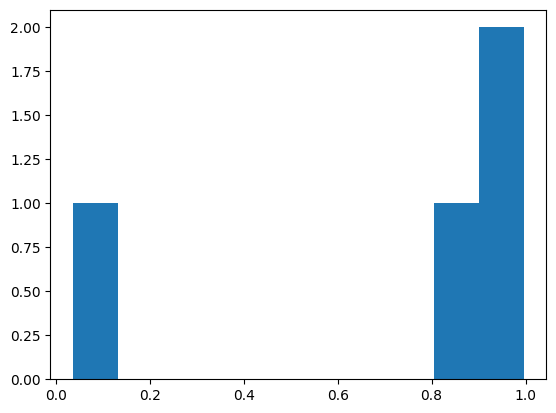

In [47]:
i = 0
for key in pnet_vars:
    if "probH" in key:
        print(key)        
        if i==0:
            a = pnet_vars[key].copy()
            i+=1
        else:
            a += pnet_vars[key].copy()

plt.hist(a)            

In [280]:
import uproot

In [291]:
f = uproot.open("../outfiles/outroot/condor_59bb95a2-3f67-11ec-b064-c6a3a983beef_%2FEvents%3B1_0-9200.root")

In [284]:
f.keys()

['Events;1']

In [289]:
f["Events"].keys()

['fj_eta',
 'fj_phi',
 'fj_mass',
 'fj_pt',
 'fj_msoftdrop',
 'matched_mask',
 'fj_genjetmass',
 'fj_genRes_pt',
 'fj_genRes_eta',
 'fj_genRes_phi',
 'fj_genRes_mass',
 'fj_nprongs',
 'fj_ncquarks',
 'fj_lepinprongs',
 'fj_H_VV_4q',
 'fj_H_VV_elenuqq',
 'fj_H_VV_munuqq',
 'fj_H_VV_leptauelvqq',
 'fj_H_VV_leptaumuvqq',
 'fj_H_VV_hadtauvqq',
 'fj_H_VV_unmatched',
 'fj_QCDb',
 'fj_QCDbb',
 'fj_QCDc',
 'fj_QCDcc',
 'fj_QCDothers',
 'fj_V_2q',
 'fj_V_elenu',
 'fj_V_munu',
 'fj_V_taunu',
 'fj_Top_bmerged',
 'fj_Top_2q',
 'fj_Top_elenu',
 'fj_Top_munu',
 'fj_Top_hadtauvqq',
 'fj_Top_leptauelvnu',
 'fj_Top_leptaumuvnu',
 'met_relpt',
 'met_relphi',
 'lep_dR_fj',
 'lep_pt',
 'lep_pt_ratio',
 'fj_ParT_probHWqqWqq0c',
 'fj_ParT_probHWqqWqq1c',
 'fj_ParT_probHWqqWqq2c',
 'fj_ParT_probHWqqWq0c',
 'fj_ParT_probHWqqWq1c',
 'fj_ParT_probHWqqWq2c',
 'fj_ParT_probHWqqWev0c',
 'fj_ParT_probHWqqWev1c',
 'fj_ParT_probHWqqWmv0c',
 'fj_ParT_probHWqqWmv1c',
 'fj_ParT_probHWqqWtauev0c',
 'fj_ParT_probHWqqWtaue

In [149]:
tagger_outputs.shape

(4, 166)

In [293]:
data = pd.read_parquet("../outfiles/0-1.parquet")
# data = pd.read_parquet("../outfiles/0-1/parquet/condor_59bb95a2-3f67-11ec-b064-c6a3a983beef_%2FEvents%3B1_0-9200.parquet")
data

,fj_eta,fj_phi,fj_mass,fj_pt,fj_msoftdrop,matched_mask,fj_genjetmass,fj_genRes_pt,fj_genRes_eta,fj_genRes_phi,...,fj_ParT_hidNeuron118,fj_ParT_hidNeuron119,fj_ParT_hidNeuron120,fj_ParT_hidNeuron121,fj_ParT_hidNeuron122,fj_ParT_hidNeuron123,fj_ParT_hidNeuron124,fj_ParT_hidNeuron125,fj_ParT_hidNeuron126,fj_ParT_hidNeuron127
0,0.274658,2.742188,28.265625,210.375,5.324219,True,32.906250,0.0,0.0,0.0,...,-0.512860,-0.271833,0.392216,0.687093,-0.773512,0.304749,-0.277003,0.323750,2.102690,0.039073
1,-0.481934,-1.735107,27.234375,231.250,21.828125,True,25.734375,0.0,0.0,0.0,...,0.634740,-0.856888,-0.009019,-0.303233,-0.294084,-0.230168,-0.575280,-1.524750,1.587073,0.777707
2,-2.750488,1.524658,3.769531,257.500,-1.000000,False,10.617188,0.0,0.0,0.0,...,-0.672889,-0.921654,0.329593,0.925229,-0.979840,-0.438818,-0.896038,-0.236780,2.699862,-0.691647
3,0.137085,2.317383,81.625000,256.750,80.937500,True,89.937500,0.0,0.0,0.0,...,0.561904,-0.728934,0.279980,-0.374802,-0.224342,0.781926,-0.954662,-0.381155,0.546435,1.428776
4,1.321045,-2.964844,88.375000,307.500,85.500000,True,85.750000,0.0,0.0,0.0,...,0.196169,-1.556378,0.896918,1.185784,-0.028637,0.555940,-0.618053,-1.395792,2.433285,2.579495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,-0.192200,0.487122,66.062500,282.250,53.375000,True,58.437500,0.0,0.0,0.0,...,1.096985,-0.399144,0.357912,0.918635,0.122019,0.324572,-0.751274,-1.215382,0.818537,1.381810
4427,1.255371,1.225098,33.187500,224.125,25.687500,True,34.718750,0.0,0.0,0.0,...,0.548983,-0.710078,0.345553,0.027846,-1.064706,-0.234013,-0.673009,-1.573321,1.058501,2.180347
4428,1.335205,2.826660,129.125000,335.000,125.437500,True,133.250000,0.0,0.0,0.0,...,0.753462,-1.521251,0.775516,1.601038,1.751955,0.597741,-1.108974,-1.253011,3.265505,0.591722
4429,0.631226,2.436035,25.312500,246.875,0.114075,True,18.078125,0.0,0.0,0.0,...,-0.334862,-1.328922,0.291813,1.369867,-0.455029,0.183487,-0.729203,-1.011796,1.522332,-0.076516


In [295]:
for key in data:
    print(key)

fj_eta
fj_phi
fj_mass
fj_pt
fj_msoftdrop
matched_mask
fj_genjetmass
fj_genRes_pt
fj_genRes_eta
fj_genRes_phi
fj_genRes_mass
fj_nprongs
fj_ncquarks
fj_lepinprongs
fj_H_VV_4q
fj_H_VV_elenuqq
fj_H_VV_munuqq
fj_H_VV_leptauelvqq
fj_H_VV_leptaumuvqq
fj_H_VV_hadtauvqq
fj_H_VV_unmatched
fj_QCDb
fj_QCDbb
fj_QCDc
fj_QCDcc
fj_QCDothers
fj_V_2q
fj_V_elenu
fj_V_munu
fj_V_taunu
fj_Top_nquarksnob
fj_Top_nbquarks
fj_Top_ncquarks
fj_Top_nleptons
fj_Top_nele
fj_Top_nmu
fj_Top_ntau
fj_Top_taudecay
met_relpt
met_relphi
lep_dR_fj
lep_pt
lep_pt_ratio
fj_ParT_probHWqqWqq0c
fj_ParT_probHWqqWqq1c
fj_ParT_probHWqqWqq2c
fj_ParT_probHWqqWq0c
fj_ParT_probHWqqWq1c
fj_ParT_probHWqqWq2c
fj_ParT_probHWqqWev0c
fj_ParT_probHWqqWev1c
fj_ParT_probHWqqWmv0c
fj_ParT_probHWqqWmv1c
fj_ParT_probHWqqWtauev0c
fj_ParT_probHWqqWtauev1c
fj_ParT_probHWqqWtaumv0c
fj_ParT_probHWqqWtaumv1c
fj_ParT_probHWqqWtauhv0c
fj_ParT_probHWqqWtauhv1c
fj_ParT_probHbb
fj_ParT_probHcc
fj_ParT_probHss
fj_ParT_probHqq
fj_ParT_probHtauhtaue
fj_ParT_prob

In [110]:
data

,fj_eta,fj_phi,fj_mass,fj_pt,fj_msoftdrop,fj_genjetmass,fj_genRes_pt,fj_genRes_eta,fj_genRes_phi,fj_genRes_mass,...,fj_ParT_hidNeuron118,fj_ParT_hidNeuron119,fj_ParT_hidNeuron120,fj_ParT_hidNeuron121,fj_ParT_hidNeuron122,fj_ParT_hidNeuron123,fj_ParT_hidNeuron124,fj_ParT_hidNeuron125,fj_ParT_hidNeuron126,fj_ParT_hidNeuron127
0,0.729858,0.618164,38.343750,226.25,12.242188,39.656250,0.0,0.0,0.0,0.0,...,-0.083720,-0.761645,0.299231,0.058961,-0.753174,0.330283,-0.774228,-0.320607,1.101451,0.272628
1,-0.493652,-1.644287,98.125000,245.75,96.687500,96.187500,0.0,0.0,0.0,0.0,...,0.901233,-1.885003,0.635751,1.138896,0.899212,1.623825,-0.971724,-1.665144,2.398521,1.571815
2,-0.088074,1.953613,49.187500,304.25,15.132812,46.468750,0.0,0.0,0.0,0.0,...,-0.141106,-0.546229,0.366121,0.201997,-1.251799,-0.101003,-0.363503,-0.546089,1.112347,0.663235
3,-1.203125,1.389648,42.625000,282.75,1.697266,40.562500,0.0,0.0,0.0,0.0,...,-0.097374,-0.190791,0.159813,0.468682,-0.702143,0.431369,-0.327314,0.110985,1.443938,0.430362
4,1.667725,-2.505859,25.828125,210.75,10.507812,17.484375,0.0,0.0,0.0,0.0,...,-0.419581,-0.420078,0.262475,0.465538,-0.381814,0.070762,-0.674171,-0.100949,1.709406,0.139051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8060,0.993408,0.913696,67.312500,310.75,24.109375,80.437500,0.0,0.0,0.0,0.0,...,0.009954,-0.537329,0.317096,-0.596470,-0.304970,0.283464,-0.529759,-0.364476,0.690377,0.337490
8061,0.229950,-2.483398,50.062500,288.25,45.781250,57.781250,0.0,0.0,0.0,0.0,...,-0.025717,-1.313964,0.643135,1.386384,-0.070378,0.561465,-0.537239,-1.150500,0.911748,1.401014
8062,0.870239,-1.356201,80.812500,225.25,79.875000,86.812500,0.0,0.0,0.0,0.0,...,0.665536,-1.623764,0.441282,1.068175,0.549156,0.632197,-1.098749,-1.420967,2.564896,1.243522
8063,0.314026,-2.881348,40.718750,232.25,3.210938,47.250000,0.0,0.0,0.0,0.0,...,-0.608205,-0.291273,0.465772,0.578688,-0.204623,0.382062,-0.349359,0.417917,1.670787,0.158220


Text(0.5, 0, 'mass [GeV]')

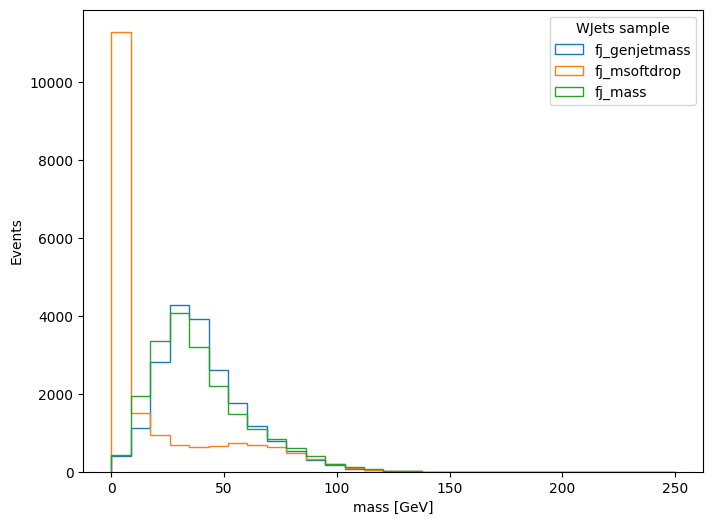

In [464]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(data["fj_genjetmass"], bins=np.linspace(0,250,30), label="fj_genjetmass", histtype="step")
ax.hist(data["fj_msoftdrop"], bins=np.linspace(0,250,30), label="fj_msoftdrop", histtype="step")
ax.hist(data["fj_mass"], bins=np.linspace(0,250,30), label="fj_mass", histtype="step")

ax.legend(title="WJets sample")
# ax.set_yscale("log")
ax.set_ylabel("Events");
ax.set_xlabel("mass [GeV]")

In [449]:
for key in data:
    print(key)

fj_eta
fj_phi
fj_mass
fj_pt
fj_msoftdrop
fj_genjetmass
fj_genRes_pt
fj_genRes_eta
fj_genRes_phi
fj_genRes_mass
fj_nprongs
fj_ncquarks
fj_lepinprongs
fj_H_VV_4q
fj_H_VV_elenuqq
fj_H_VV_munuqq
fj_H_VV_leptauelvqq
fj_H_VV_leptaumuvqq
fj_H_VV_hadtauvqq
fj_H_VV_unmatched
fj_QCDb
fj_QCDbb
fj_QCDc
fj_QCDcc
fj_QCDothers
fj_V_2q
fj_V_elenu
fj_V_munu
fj_V_taunu
fj_Top_bmerged
fj_Top_2q
fj_Top_elenu
fj_Top_munu
fj_Top_hadtauvqq
fj_Top_leptauelvnu
fj_Top_leptaumuvnu
met_relpt
met_relphi
lep_dR_fj
lep_pt
lep_pt_ratio
fj_PN_v2_noreg_probHWqqWqq0c
fj_PN_v2_noreg_probHWqqWqq1c
fj_PN_v2_noreg_probHWqqWqq2c
fj_PN_v2_noreg_probHWqqWq0c
fj_PN_v2_noreg_probHWqqWq1c
fj_PN_v2_noreg_probHWqqWq2c
fj_PN_v2_noreg_probHWqqWev0c
fj_PN_v2_noreg_probHWqqWev1c
fj_PN_v2_noreg_probHWqqWmv0c
fj_PN_v2_noreg_probHWqqWmv1c
fj_PN_v2_noreg_probHWqqWtauev0c
fj_PN_v2_noreg_probHWqqWtauev1c
fj_PN_v2_noreg_probHWqqWtaumv0c
fj_PN_v2_noreg_probHWqqWtaumv1c
fj_PN_v2_noreg_probHWqqWtauhv0c
fj_PN_v2_noreg_probHWqqWtauhv1c
fj_PN_v2_no

In [35]:
i = 0
for key in data:
    if "probTop" in key:
        print(key)        
        if i==0:
            a = data[key].copy()
            i+=1
        else:
            a += data[key].copy()

fj_PN_v2_noreg_probTopbWqq0c
fj_PN_v2_noreg_probTopbWqq1c
fj_PN_v2_noreg_probTopbWq0c
fj_PN_v2_noreg_probTopbWq1c
fj_PN_v2_noreg_probTopbWev
fj_PN_v2_noreg_probTopbWmv
fj_PN_v2_noreg_probTopbWtauhv
fj_PN_v2_noreg_probTopbWtauev
fj_PN_v2_noreg_probTopbWtaumv


In [37]:
a

0      -6.174962
1       0.090494
2      -4.951981
3      -7.249495
4      -4.026866
          ...   
8060   -5.504247
8061   -9.608588
8062    1.856335
8063   -7.813547
8064   -3.839128
Name: fj_PN_v2_noreg_probTopbWqq0c, Length: 8065, dtype: float32

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

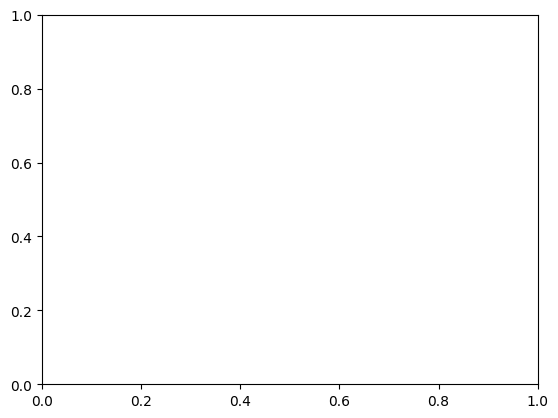

In [450]:
plt.hist(a)

In [448]:
i = 0
for key in data:
    if "H_" in key:
        print(key)        
        if i==0:
            a = data[key].copy()
            i+=1
        else:
            a += data[key].copy()

fj_H_VV_4q
fj_H_VV_elenuqq
fj_H_VV_munuqq
fj_H_VV_leptauelvqq
fj_H_VV_leptaumuvqq
fj_H_VV_hadtauvqq
fj_H_VV_unmatched


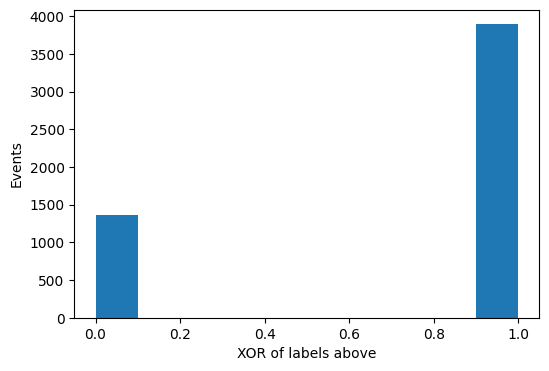

In [454]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(a)

# ax.set_yscale("log")
ax.set_ylabel("Events");
ax.set_xlabel("XOR of labels above");

In [259]:
for model in tagger_outputs:
    print(f"{model}: {np.isnan(tagger_outputs[model].sum(axis=1)).sum()} out of {len(tagger_outputs[model])} jets have Nan output")

particlenet_hww_inclv2_pre2: 0 out of 265 jets have Nan output
particlenet_hww_inclv2_pre2_noreg: 0 out of 265 jets have Nan output
ak8_MD_vminclv2ParT_manual_fixwrap: 62 out of 265 jets have Nan output
ak8_MD_vminclv2ParT_manual_fixwrap_all_nodes: 62 out of 265 jets have Nan output


In [260]:
tagger_outputs["ak8_MD_vminclv2ParT_manual_fixwrap_all_nodes"]

array([[5.1007355e-05, 1.8626453e-05, 1.9213767e-06, ..., 4.8398793e-05,
        9.8489586e-04, 1.6460972e-07],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [2.2208393e-07, 4.3564185e-07, 2.0552493e-07, ..., 3.6111782e-05,
        3.4498496e-06, 1.4317316e-02],
       [9.9135532e-06, 2.9095775e-06, 3.2973554e-07, ..., 5.9618754e-04,
        4.7398992e-03, 6.9986794e-07],
       [3.1972013e-05, 1.0254228e-05, 6.8656732e-07, ..., 1.5066316e-03,
        1.3666394e-02, 4.9941955e-06]], dtype=float32)

In [261]:
tagger_outputs["ak8_MD_vminclv2ParT_manual_fixwrap"]

array([[5.10072277e-05, 1.86264388e-05, 1.92137372e-06, ...,
        4.83986623e-05, 9.84894228e-04, 1.64609276e-07],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [2.22084012e-07, 4.35642022e-07, 2.05525225e-07, ...,
        3.61117964e-05, 3.44985438e-06, 1.43173095e-02],
       [9.91355319e-06, 2.90957746e-06, 3.29735883e-07, ...,
        5.96187252e-04, 4.73989919e-03, 6.99867257e-07],
       [3.20316794e-05, 1.02746299e-05, 6.87794852e-07, ...,
        1.50883675e-03, 1.36840269e-02, 4.98432291e-06]], dtype=float32)